# Initial Setup

In [ ]:
!pip install tensorflow==2.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tensorflow_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import re
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, GRU, Bidirectional, Reshape, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, SpatialDropout1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Loading Dataset

In [ ]:
positif = pd.read_csv('/content/drive/MyDrive/SKRIPSI/training/data_positif_baru.csv')

positif

,CleanTweets,label
0,abang abang jne sicepat ninja baik baik benar si,positif
1,abang abang sicepat ramah ya,positif
2,abang ambil ninja express baik sekali cepat lagi,positif
3,abang jne barusan antar paket manis sekali bai...,positif
4,abang jnt express mah memang cepat mantap betul,positif
...,...,...
1995,ya teh dulu guna setia tiki mahal tiki jne pak...,positif
1996,ya tidak sangka cepat banget tertawa pakai jne...,positif
1997,ya tuhan kaget banget baru tahu kirim paket pa...,positif
1998,zaman banyak belanja daring sicepat rebut hati,positif


In [ ]:
negatif = pd.read_csv('/content/drive/MyDrive/SKRIPSI/training/data_negatif_baru.csv')

negatif

,CleanTweets,label
0,abah memang sicepat lambat sekali ya allah pak...,negatif
1,abang abang anteraja hilang melulu ih pagi pag...,negatif
2,abang abang jne lagi sih hari status proses as...,negatif
3,abang jne sudah sampai gedor gedor pagar tidak...,negatif
4,abang jne tunggu pagi tidak datang datang awas...,negatif
...,...,...
1995,ya tuhan sebut kasar sicepat badut oh badut,negatif
1996,ya tuhan tahu begitu kemarin tidak pilih ekspe...,negatif
1997,yakin jual nya curang respons sudah beli saja ...,negatif
1998,yakin tidak gulung tikar merosot,negatif


In [ ]:
netral = pd.read_csv('/content/drive/MyDrive/SKRIPSI/training/data_netral_baru.csv')

netral

,CleanTweets,label
0,abad pemudi tidak bisa pesan gosend,netral
1,abadi momen metal lagi jam an gosend tidak bis...,netral
2,abang abang anteraja bosan tidak ya rumah melulu,netral
3,abang abang anteraja mau ambil tanya minggu ac...,netral
4,abang abang anteraja niat sekali sampai video ...,netral
...,...,...
1995,zaman semester berapa ya lupa gosend diska lep...,netral
1996,zen bawa juta negosiasi tipis atas boleh pesan...,netral
1997,zona merah akhir suruh gosend kak,netral
1998,zona uang kode promo kupon gosend bisa cepat,netral


In [ ]:
# menggabungkan data ke dalam dataset

data = pd.concat([positif, negatif, netral])
data.reset_index(drop=True, inplace = True)

data

,CleanTweets,label
0,abang abang jne sicepat ninja baik baik benar si,positif
1,abang abang sicepat ramah ya,positif
2,abang ambil ninja express baik sekali cepat lagi,positif
3,abang jne barusan antar paket manis sekali bai...,positif
4,abang jnt express mah memang cepat mantap betul,positif
...,...,...
5995,zaman semester berapa ya lupa gosend diska lep...,netral
5996,zen bawa juta negosiasi tipis atas boleh pesan...,netral
5997,zona merah akhir suruh gosend kak,netral
5998,zona uang kode promo kupon gosend bisa cepat,netral


In [ ]:
# shuffle data

data_shuffle = data.sample(frac=1.0, random_state=42)

data_shuffle.head()

,CleanTweets,label
1782,surabaya ongkos pesan kemarin pagi pagi sudah ...,positif
3917,tumben tidak masalah pakai tik jne sudah dafta...,negatif
221,beli toko pakai kurir sicepat halu pagi drop g...,positif
2135,amuk amuk jne tidak solusional,negatif
5224,malam kak mohon maaf perihal administrator ban...,netral


In [ ]:
data_shuffle.dtypes

CleanTweets    object
label          object
dtype: object

In [ ]:
data_shuffle.isna().sum()

CleanTweets    0
label          0
dtype: int64

# Dataset Exploration

In [ ]:
print("Jumlah data: %s" % len(data_shuffle.index))

Jumlah data: 6000


In [ ]:
data_shuffle.groupby('label').size()

label
negatif    2000
netral     2000
positif    2000
dtype: int64

In [ ]:
print("Kalimat terpanjang: %s kata" % data_shuffle['CleanTweets'].str.split().str.len().max())
print("Kalimat terpendek: %s kata" % data_shuffle['CleanTweets'].str.split().str.len().min())
print("Rata-rata panjang kalimat: %s kata" % data_shuffle['CleanTweets'].str.split().str.len().mean())

Kalimat terpanjang: 39 kata
Kalimat terpendek: 1 kata
Rata-rata panjang kalimat: 11.951166666666667 kata


In [ ]:
data_shuffle.isna().sum()

CleanTweets    0
label          0
dtype: int64

In [ ]:
data_shuffle.dtypes

CleanTweets    object
label          object
dtype: object

In [ ]:
train_df = data_shuffle.sample(frac=0.8, random_state=9) #random state is a seed value
dev_test_df = data_shuffle.drop(train_df.index)

dev_df = dev_test_df.sample(frac=0.5, random_state=9)
test_df = dev_test_df.drop(dev_df.index)

In [ ]:
train_df.groupby('label').size()

label
negatif    1589
netral     1583
positif    1628
dtype: int64

In [ ]:
dev_df.groupby('label').size()

label
negatif    205
netral     212
positif    183
dtype: int64

In [ ]:
test_df.groupby('label').size()

label
negatif    206
netral     205
positif    189
dtype: int64

In [ ]:
train_set = train_df['CleanTweets'].to_numpy()
dev_set = dev_df['CleanTweets'].to_numpy()
test_set = test_df['CleanTweets'].to_numpy()

train_labels = train_df['label'].to_numpy()
dev_labels = dev_df['label'].to_numpy()
test_labels = test_df['label'].to_numpy()

print(train_set[0])
print(train_labels[0])

resi status sudah terima terima bilang belum terima mohon
negatif


In [ ]:
le = LabelEncoder()
le.fit(train_labels)
print(list(le.classes_))

train_num_labels = le.fit_transform(train_labels).astype('float')
dev_num_labels = le.fit_transform(dev_labels).astype('float')
test_num_labels = le.fit_transform(test_labels).astype('float')
print(train_num_labels[0:10])

['negatif', 'netral', 'positif']
[0. 1. 1. 2. 0. 2. 2. 0. 0. 0.]


# Text to Sequence

In [ ]:
def tokenize_text_to_sequence(train, dev, test, maxlen):
    tokenizer = Tokenizer(
        filters='', # '!"#$%&()*+,./:;=?@[\\]^_`{|}~\t\n', # Excluding - and '
        lower=True,
        # oov_token="<UNK>"
    )

    tokenizer.fit_on_texts(train)
        
    X_train = tokenizer.texts_to_sequences(train)
    X_dev = tokenizer.texts_to_sequences(dev)
    X_test = tokenizer.texts_to_sequences(test)
    
    X_train = pad_sequences(X_train, padding='post', truncating='post', maxlen=maxlen)
    X_dev = pad_sequences(X_dev, padding='post', truncating='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', truncating='post', maxlen=maxlen)

    return X_train, X_dev, X_test, len(tokenizer.word_index) + 1, tokenizer.word_index, tokenizer

In [ ]:
maxlen = 100 # panjang sequence untuk RNN (jumlah timesteps)
embedding_dim = 128 # jumlah dimensi dari embedding

In [ ]:
X_train_seq, X_dev_seq, X_test_seq, vocab_size, word_index, tokenizer_training = tokenize_text_to_sequence(train_set, dev_set, test_set, maxlen)
print("Vocab size: %s" % vocab_size)

y_train = to_categorical(train_num_labels, 3)
y_dev = to_categorical(dev_num_labels, 3)
y_test = to_categorical(test_num_labels, 3)

print(train_set[5])
print(X_train_seq[5])
print(y_train[5])

Vocab size: 2412
sumpah sih lebih bagus pakai kurir cepat jelas sekali barang bawa kurir nomor bisa hubung
[166  33  29  81   4  21  10 107  18  16 155  21  42  13  79   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
[0. 0. 1.]


# Building Model

In [ ]:
def print_metric(y_test, y_pred):
    acc_test = accuracy_score(y_test, y_pred)
    precision_test_ma = precision_score(y_test, y_pred, average='macro')
    precision_test_mi = precision_score(y_test, y_pred, average='micro')
    recall_test_ma = recall_score(y_test, y_pred, average='macro')
    recall_test_mi = recall_score(y_test, y_pred, average='micro')
    f1_test_ma = f1_score(y_test, y_pred, average='macro')
    f1_test_mi = f1_score(y_test, y_pred, average='micro')

    print("Test score: Macro / Micro")
    print()
    print("Accuracy: {:8.3f}".format(acc_test))
    print("F1: {:14.3f} / {:2.3f}".format(f1_test_ma, f1_test_mi))
    print("Precision: {:7.3f} / {:2.3f}".format(precision_test_ma, precision_test_mi))
    print("Recall: {:10.3f} / {:2.3f}".format(recall_test_ma, recall_test_mi))
    print("Confusion matrix: ")

    cm = confusion_matrix(y_test, y_pred, labels=[0.0,1.0,2.0])
    _, ax = plt.subplots(figsize=(6, 3))
    sns.heatmap(cm, annot=True, ax=ax, fmt='d')
    ax.set_xlabel('Predicted labels')
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel('True labels')
    ax.xaxis.set_ticklabels(['negatif', 'netral', 'positif'])
    ax.xaxis.tick_top()
    ax.yaxis.set_ticklabels(['negatif', 'netral', 'positif'])

    plt.show()
    print()

metrics = [
    tf.keras.metrics.TruePositives(name='TruePositive'),
    tf.keras.metrics.FalsePositives(name='FalsePositive'),
    tf.keras.metrics.TrueNegatives(name='TrueNegative'),
    tf.keras.metrics.FalseNegatives(name='FalseNegative'), 
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

## CNN-LSTM - with recurrent dropout + dropout 1 (50 epochs)

In [ ]:
# TODO: Model CNN-LSTM

def cnn_lstm_model1():
    model = Sequential()
    model.add(Embedding(vocab_size,
                    embedding_dim,
                    input_length=maxlen,
                    trainable=True))

    model.add(Conv1D(filters = 100, kernel_size = 5, strides = 1, padding = 'same', activation = 'relu'))
    model.add(Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True,))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    opt = Adam(learning_rate=0.001)

    model.compile(
        loss="categorical_crossentropy", 
        optimizer=opt, 
        metrics=metrics
    )

    return model

In [ ]:
cnn_lstm_model1 = cnn_lstm_model1()
cnn_lstm_model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 128)          308736    
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 100)          64100     
                                                                 
 conv1d_3 (Conv1D)           (None, 100, 64)           19264     
                                                                 
 lstm_1 (LSTM)               (None, 100, 128)          98816     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                      

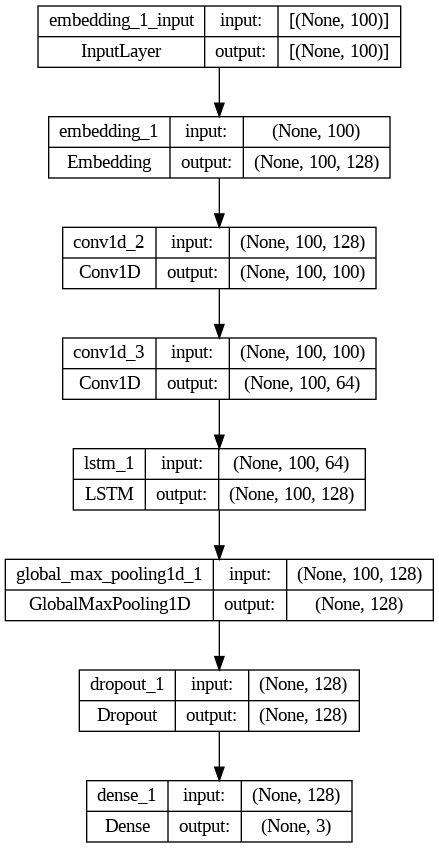

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(cnn_lstm_model1, to_file='model_plot_cnn_lstm_model1.png', show_shapes=True, show_layer_names=True)

In [ ]:
cnn_lstm_model_history1 = cnn_lstm_model1.fit(X_train_seq, y_train, 
                    epochs=50, 
                    verbose=True, 
                    validation_data=(X_dev_seq, y_dev), 
                    batch_size=128
                    # callbacks=[EarlyStopping(monitor="val_loss", patience=2)]
                    )

Epoch 1/50
38/38 [==============================] - 48s 1s/step - loss: 1.0218 - TruePositive: 466.0000 - FalsePositive: 112.0000 - TrueNegative: 11280.0000 - FalseNegative: 5230.0000 - accuracy: 0.4480 - precision: 0.8062 - recall: 0.0818 - val_loss: 0.6446 - val_TruePositive: 432.0000 - val_FalsePositive: 112.0000 - val_TrueNegative: 1088.0000 - val_FalseNegative: 168.0000 - val_accuracy: 0.7533 - val_precision: 0.7941 - val_recall: 0.7200
Epoch 2/50
38/38 [==============================] - 45s 1s/step - loss: 0.5503 - TruePositive: 3733.0000 - FalsePositive: 862.0000 - TrueNegative: 8738.0000 - FalseNegative: 1067.0000 - accuracy: 0.7979 - precision: 0.8124 - recall: 0.7777 - val_loss: 0.4672 - val_TruePositive: 486.0000 - val_FalsePositive: 93.0000 - val_TrueNegative: 1107.0000 - val_FalseNegative: 114.0000 - val_accuracy: 0.8217 - val_precision: 0.8394 - val_recall: 0.8100
Epoch 3/50
38/38 [==============================] - 48s 1s/step - loss: 0.3549 - TruePositive: 4176.0000 - Fa

In [ ]:
cnn_lstm_test_soft1 = cnn_lstm_model1.predict(X_test_seq)
cnn_lstm_test1 = np.argmax(cnn_lstm_test_soft1, axis=1)

19/19 [==============================] - 3s 88ms/step


Test score: Macro / Micro

Accuracy:    0.812
F1:          0.811 / 0.812
Precision:   0.811 / 0.812
Recall:      0.812 / 0.812
Confusion matrix: 


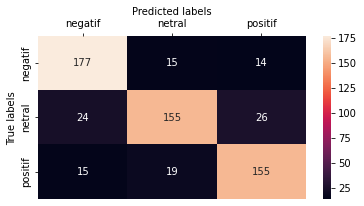

In [ ]:
print_metric(test_num_labels, cnn_lstm_test1)

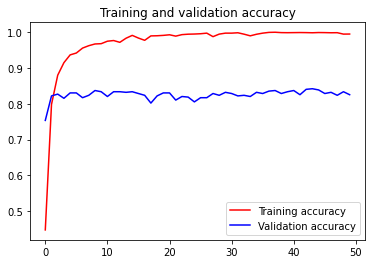

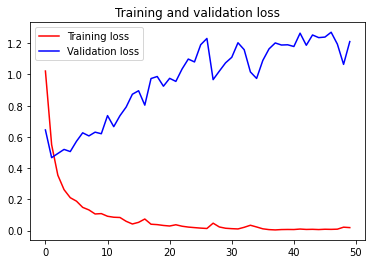

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the training and validation accuracies for each epoch

acc = cnn_lstm_model_history1.history['accuracy']
val_acc = cnn_lstm_model_history1.history['val_accuracy']
loss = cnn_lstm_model_history1.history['loss']
val_loss = cnn_lstm_model_history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
cnn_lstm_model1.save('/content/drive/MyDrive/SKRIPSI/Model/cnn_lstm_model1_99-82.h5')

## CNN-LSTM - with recurrent dropout + dropout 2 (20 epochs)

In [ ]:
# TODO: Model CNN-LSTM

def cnn_lstm_model2():
    model = Sequential()
    model.add(Embedding(vocab_size,
                    embedding_dim,
                    input_length=maxlen,
                    trainable=True))

    model.add(Conv1D(filters = 100, kernel_size = 5, strides = 1, padding = 'same', activation = 'relu'))
    model.add(Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True,))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    opt = Adam(learning_rate=0.001)

    model.compile(
        loss="categorical_crossentropy", 
        optimizer=opt, 
        metrics=metrics
    )

    return model

In [ ]:
cnn_lstm_model2 = cnn_lstm_model2()
cnn_lstm_model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 128)          308736    
                                                                 
 conv1d_4 (Conv1D)           (None, 100, 100)          64100     
                                                                 
 conv1d_5 (Conv1D)           (None, 100, 64)           19264     
                                                                 
 lstm_2 (LSTM)               (None, 100, 128)          98816     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                      

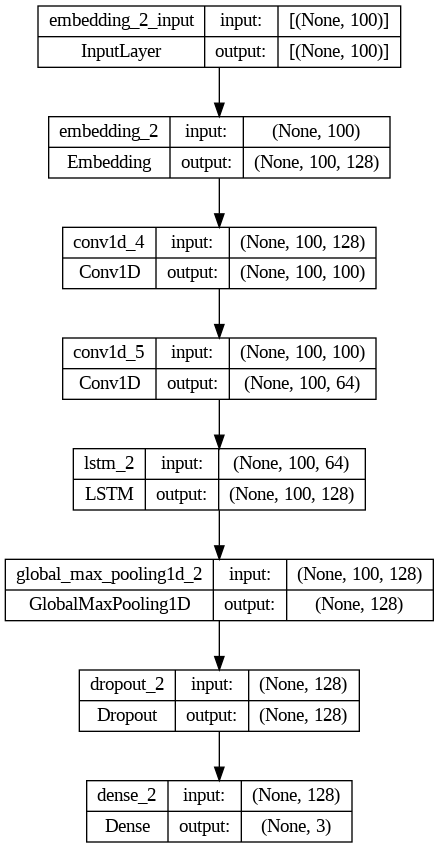

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(cnn_lstm_model2, to_file='model_plot_cnn_lstm_model2.png', show_shapes=True, show_layer_names=True)

In [ ]:
cnn_lstm_model_history2 = cnn_lstm_model2.fit(X_train_seq, y_train, 
                    epochs=20, 
                    verbose=True, 
                    validation_data=(X_dev_seq, y_dev), 
                    batch_size=128
                    # callbacks=[EarlyStopping(monitor="val_loss", patience=2)]
                    )

Epoch 1/20
38/38 [==============================] - 52s 1s/step - loss: 1.0206 - TruePositive: 1036.0000 - FalsePositive: 295.0000 - TrueNegative: 10505.0000 - FalseNegative: 4364.0000 - accuracy: 0.4970 - precision: 0.7784 - recall: 0.1919 - val_loss: 0.7640 - val_TruePositive: 308.0000 - val_FalsePositive: 67.0000 - val_TrueNegative: 1133.0000 - val_FalseNegative: 292.0000 - val_accuracy: 0.7117 - val_precision: 0.8213 - val_recall: 0.5133
Epoch 2/20
38/38 [==============================] - 45s 1s/step - loss: 0.5509 - TruePositive: 3671.0000 - FalsePositive: 748.0000 - TrueNegative: 8852.0000 - FalseNegative: 1129.0000 - accuracy: 0.8069 - precision: 0.8307 - recall: 0.7648 - val_loss: 0.4914 - val_TruePositive: 490.0000 - val_FalsePositive: 92.0000 - val_TrueNegative: 1108.0000 - val_FalseNegative: 110.0000 - val_accuracy: 0.8283 - val_precision: 0.8419 - val_recall: 0.8167
Epoch 3/20
38/38 [==============================] - 43s 1s/step - loss: 0.3428 - TruePositive: 4212.0000 - Fa

In [ ]:
cnn_lstm_test_soft2 = cnn_lstm_model2.predict(X_test_seq)
cnn_lstm_test2 = np.argmax(cnn_lstm_test_soft2, axis=1)

19/19 [==============================] - 2s 54ms/step


Test score: Macro / Micro

Accuracy:    0.815
F1:          0.815 / 0.815
Precision:   0.821 / 0.815
Recall:      0.817 / 0.815
Confusion matrix: 


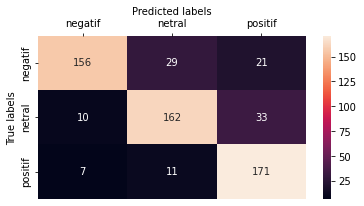

In [ ]:
print_metric(test_num_labels, cnn_lstm_test2)

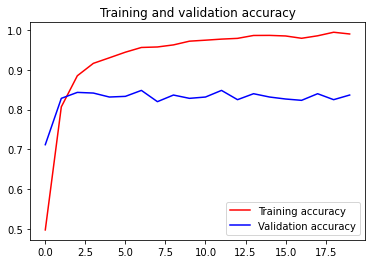

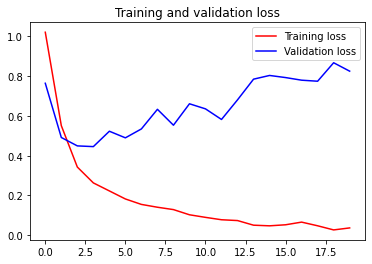

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the training and validation accuracies for each epoch

acc = cnn_lstm_model_history2.history['accuracy']
val_acc = cnn_lstm_model_history2.history['val_accuracy']
loss = cnn_lstm_model_history2.history['loss']
val_loss = cnn_lstm_model_history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
cnn_lstm_model2.save('/content/drive/MyDrive/SKRIPSI/Model/cnn_lstm_model2_99-83_20epochs.h5')

## CNN-LSTM - with recurrent dropout + dropout 3 (with early stopping) - Best Fit

In [ ]:
# TODO: Model CNN-LSTM

def cnn_lstm_model3():
    model = Sequential()
    model.add(Embedding(vocab_size,
                    embedding_dim,
                    input_length=maxlen,
                    trainable=True))

    model.add(Conv1D(filters = 100, kernel_size = 5, strides = 1, padding = 'same', activation = 'relu'))
    model.add(Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True,))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    opt = Adam(learning_rate=0.001)

    model.compile(
        loss="categorical_crossentropy", 
        optimizer=opt, 
        metrics=metrics
    )

    return model

In [ ]:
cnn_lstm_model3 = cnn_lstm_model3()
cnn_lstm_model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 128)          308736    
                                                                 
 conv1d_6 (Conv1D)           (None, 100, 100)          64100     
                                                                 
 conv1d_7 (Conv1D)           (None, 100, 64)           19264     
                                                                 
 lstm_3 (LSTM)               (None, 100, 128)          98816     
                                                                 
 global_max_pooling1d_3 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                      

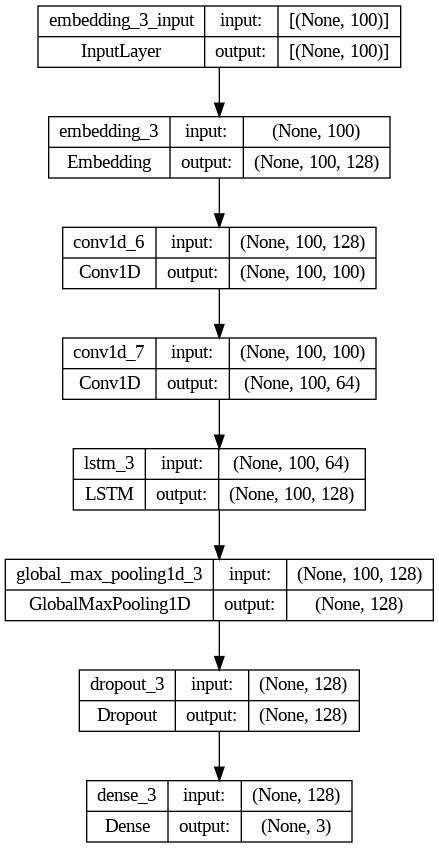

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(cnn_lstm_model3, to_file='model_plot_cnn_lstm_model3.png', show_shapes=True, show_layer_names=True)

In [ ]:
cnn_lstm_model_history3 = cnn_lstm_model3.fit(X_train_seq, y_train, 
                    epochs=20, 
                    verbose=True, 
                    validation_data=(X_dev_seq, y_dev), 
                    batch_size=128,
                    callbacks=[EarlyStopping(monitor="val_loss", patience=2)]
                    )

Epoch 1/20
38/38 [==============================] - 49s 1s/step - loss: 1.0463 - TruePositive: 793.0000 - FalsePositive: 208.0000 - TrueNegative: 10592.0000 - FalseNegative: 4607.0000 - accuracy: 0.4741 - precision: 0.7922 - recall: 0.1469 - val_loss: 0.8396 - val_TruePositive: 204.0000 - val_FalsePositive: 69.0000 - val_TrueNegative: 1131.0000 - val_FalseNegative: 396.0000 - val_accuracy: 0.6900 - val_precision: 0.7473 - val_recall: 0.3400
Epoch 2/20
38/38 [==============================] - 46s 1s/step - loss: 0.5588 - TruePositive: 3611.0000 - FalsePositive: 723.0000 - TrueNegative: 8877.0000 - FalseNegative: 1189.0000 - accuracy: 0.8010 - precision: 0.8332 - recall: 0.7523 - val_loss: 0.5268 - val_TruePositive: 484.0000 - val_FalsePositive: 97.0000 - val_TrueNegative: 1103.0000 - val_FalseNegative: 116.0000 - val_accuracy: 0.8233 - val_precision: 0.8330 - val_recall: 0.8067
Epoch 3/20
38/38 [==============================] - 45s 1s/step - loss: 0.3467 - TruePositive: 4204.0000 - Fal

In [ ]:
cnn_lstm_test_soft3 = cnn_lstm_model3.predict(X_test_seq)
cnn_lstm_test3 = np.argmax(cnn_lstm_test_soft3, axis=1)

19/19 [==============================] - 4s 123ms/step


Test score: Macro / Micro

Accuracy:    0.838
F1:          0.838 / 0.838
Precision:   0.840 / 0.838
Recall:      0.840 / 0.838
Confusion matrix: 


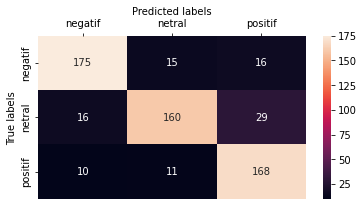

In [ ]:
print_metric(test_num_labels, cnn_lstm_test3)

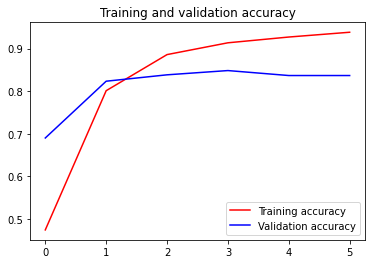

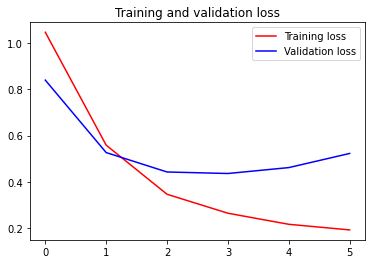

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the training and validation accuracies for each epoch

acc = cnn_lstm_model_history3.history['accuracy']
val_acc = cnn_lstm_model_history3.history['val_accuracy']
loss = cnn_lstm_model_history3.history['loss']
val_loss = cnn_lstm_model_history3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
cnn_lstm_model3.save('/content/drive/MyDrive/SKRIPSI/Model/cnn_lstm_model3_93-83_earlystopping.h5')

## CNN-LSTM - with recurrent dropout + dropout 4 (dropout 0.2)

In [ ]:
# TODO: Model CNN-LSTM

def cnn_lstm_model4():
    model = Sequential()
    model.add(Embedding(vocab_size,
                    embedding_dim,
                    input_length=maxlen,
                    trainable=True))

    model.add(Conv1D(filters = 100, kernel_size = 5, strides = 1, padding = 'same', activation = 'relu'))
    model.add(Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True,))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))

    opt = Adam(learning_rate=0.001)

    model.compile(
        loss="categorical_crossentropy", 
        optimizer=opt, 
        metrics=metrics
    )

    return model

In [ ]:
cnn_lstm_model4 = cnn_lstm_model4()
cnn_lstm_model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 128)          308736    
                                                                 
 conv1d_8 (Conv1D)           (None, 100, 100)          64100     
                                                                 
 conv1d_9 (Conv1D)           (None, 100, 64)           19264     
                                                                 
 lstm_4 (LSTM)               (None, 100, 128)          98816     
                                                                 
 global_max_pooling1d_4 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                      

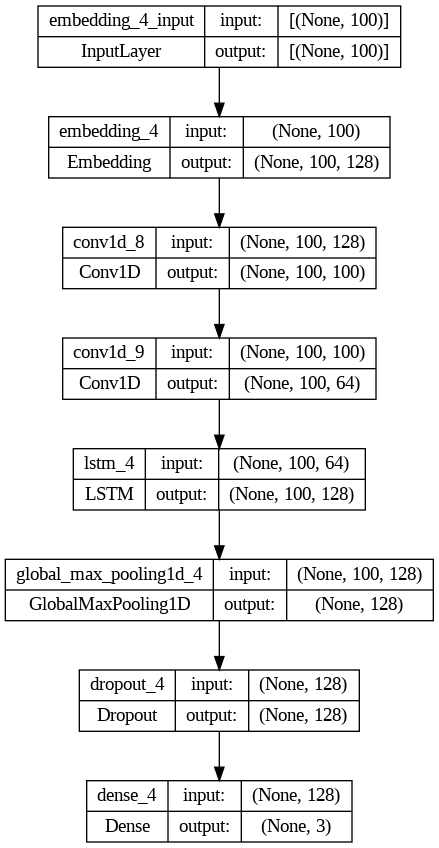

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(cnn_lstm_model4, to_file='model_plot_cnn_lstm_model4.png', show_shapes=True, show_layer_names=True)

In [ ]:
cnn_lstm_model_history4 = cnn_lstm_model4.fit(X_train_seq, y_train, 
                    epochs=20, 
                    verbose=True, 
                    validation_data=(X_dev_seq, y_dev), 
                    batch_size=128,
                    callbacks=[EarlyStopping(monitor="val_loss", patience=2)]
                    )

Epoch 1/20
38/38 [==============================] - 52s 1s/step - loss: 0.9872 - TruePositive: 1318.0000 - FalsePositive: 420.0000 - TrueNegative: 10380.0000 - FalseNegative: 4082.0000 - accuracy: 0.5252 - precision: 0.7583 - recall: 0.2441 - val_loss: 0.6865 - val_TruePositive: 416.0000 - val_FalsePositive: 112.0000 - val_TrueNegative: 1088.0000 - val_FalseNegative: 184.0000 - val_accuracy: 0.7500 - val_precision: 0.7879 - val_recall: 0.6933
Epoch 2/20
38/38 [==============================] - 43s 1s/step - loss: 0.4447 - TruePositive: 3924.0000 - FalsePositive: 662.0000 - TrueNegative: 8938.0000 - FalseNegative: 876.0000 - accuracy: 0.8381 - precision: 0.8556 - recall: 0.8175 - val_loss: 0.4264 - val_TruePositive: 488.0000 - val_FalsePositive: 91.0000 - val_TrueNegative: 1109.0000 - val_FalseNegative: 112.0000 - val_accuracy: 0.8300 - val_precision: 0.8428 - val_recall: 0.8133
Epoch 3/20
38/38 [==============================] - 40s 1s/step - loss: 0.2929 - TruePositive: 4249.0000 - Fa

In [ ]:
cnn_lstm_test_soft4 = cnn_lstm_model4.predict(X_test_seq)
cnn_lstm_test4 = np.argmax(cnn_lstm_test_soft4, axis=1)

19/19 [==============================] - 1s 55ms/step


Test score: Macro / Micro

Accuracy:    0.847
F1:          0.846 / 0.847
Precision:   0.849 / 0.847
Recall:      0.848 / 0.847
Confusion matrix: 


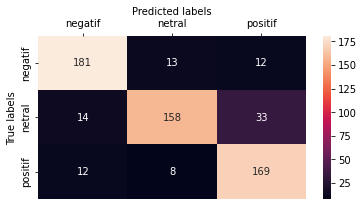

In [ ]:
print_metric(test_num_labels, cnn_lstm_test4)

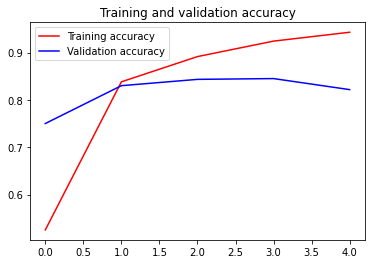

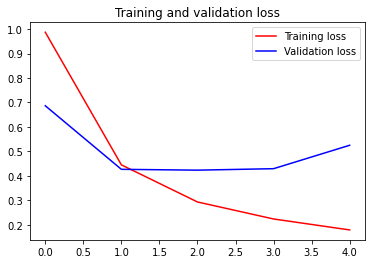

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the training and validation accuracies for each epoch

acc = cnn_lstm_model_history4.history['accuracy']
val_acc = cnn_lstm_model_history4.history['val_accuracy']
loss = cnn_lstm_model_history4.history['loss']
val_loss = cnn_lstm_model_history4.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
cnn_lstm_model4.save('/content/drive/MyDrive/SKRIPSI/Model/cnn_lstm_model4_94-82_dropout02.h5')

## CNN-LSTM - no dropout layer 5

In [ ]:
# TODO: Model CNN-LSTM

def cnn_lstm_model5():
    model = Sequential()
    model.add(Embedding(vocab_size,
                    embedding_dim,
                    input_length=maxlen,
                    trainable=True))

    model.add(Conv1D(filters = 100, kernel_size = 5, strides = 1, padding = 'same', activation = 'relu'))
    model.add(Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True,))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(3, activation='softmax'))

    opt = Adam(learning_rate=0.001)

    model.compile(
        loss="categorical_crossentropy", 
        optimizer=opt, 
        metrics=metrics
    )

    return model

In [ ]:
cnn_lstm_model5 = cnn_lstm_model5()
cnn_lstm_model5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 128)          308736    
                                                                 
 conv1d_10 (Conv1D)          (None, 100, 100)          64100     
                                                                 
 conv1d_11 (Conv1D)          (None, 100, 64)           19264     
                                                                 
 lstm_5 (LSTM)               (None, 100, 128)          98816     
                                                                 
 global_max_pooling1d_5 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_5 (Dense)             (None, 3)                 387       
                                                      

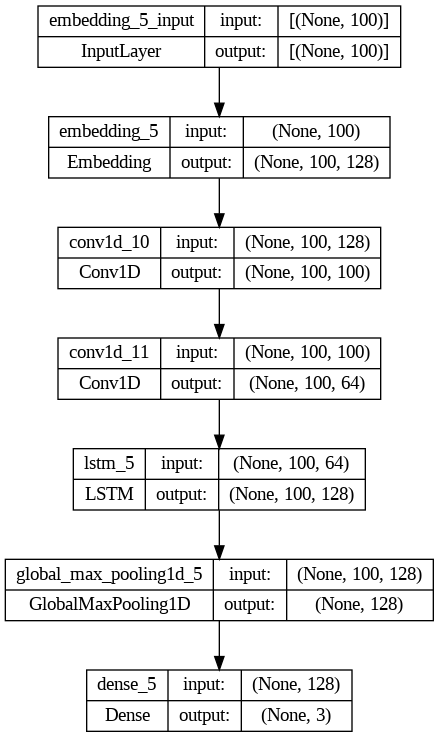

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(cnn_lstm_model5, to_file='model_plot_cnn_lstm_model5.png', show_shapes=True, show_layer_names=True)

In [ ]:
cnn_lstm_model_history5 = cnn_lstm_model5.fit(X_train_seq, y_train, 
                    epochs=20, 
                    verbose=True, 
                    validation_data=(X_dev_seq, y_dev), 
                    batch_size=128,
                    callbacks=[EarlyStopping(monitor="val_loss", patience=2)]
                    )

Epoch 1/20
38/38 [==============================] - 54s 1s/step - loss: 0.9880 - TruePositive: 1196.0000 - FalsePositive: 330.0000 - TrueNegative: 10470.0000 - FalseNegative: 4204.0000 - accuracy: 0.5306 - precision: 0.7837 - recall: 0.2215 - val_loss: 0.6853 - val_TruePositive: 401.0000 - val_FalsePositive: 145.0000 - val_TrueNegative: 1055.0000 - val_FalseNegative: 199.0000 - val_accuracy: 0.7017 - val_precision: 0.7344 - val_recall: 0.6683
Epoch 2/20
38/38 [==============================] - 42s 1s/step - loss: 0.4638 - TruePositive: 3828.0000 - FalsePositive: 730.0000 - TrueNegative: 8870.0000 - FalseNegative: 972.0000 - accuracy: 0.8179 - precision: 0.8398 - recall: 0.7975 - val_loss: 0.4732 - val_TruePositive: 487.0000 - val_FalsePositive: 92.0000 - val_TrueNegative: 1108.0000 - val_FalseNegative: 113.0000 - val_accuracy: 0.8250 - val_precision: 0.8411 - val_recall: 0.8117
Epoch 3/20
38/38 [==============================] - 44s 1s/step - loss: 0.2866 - TruePositive: 4270.0000 - Fa

In [ ]:
cnn_lstm_test_soft5 = cnn_lstm_model5.predict(X_test_seq)
cnn_lstm_test5 = np.argmax(cnn_lstm_test_soft5, axis=1)

19/19 [==============================] - 1s 54ms/step


Test score: Macro / Micro

Accuracy:    0.835
F1:          0.834 / 0.835
Precision:   0.835 / 0.835
Recall:      0.835 / 0.835
Confusion matrix: 


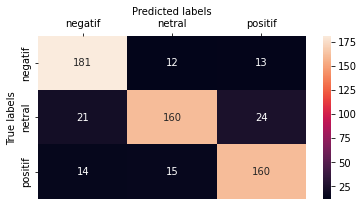

In [ ]:
print_metric(test_num_labels, cnn_lstm_test5)

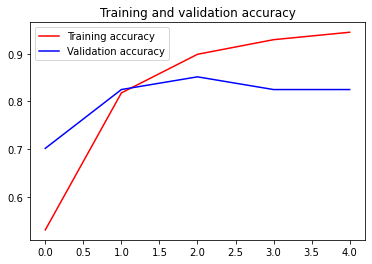

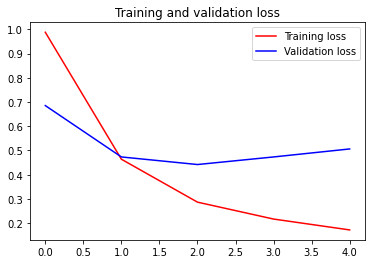

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the training and validation accuracies for each epoch

acc = cnn_lstm_model_history5.history['accuracy']
val_acc = cnn_lstm_model_history5.history['val_accuracy']
loss = cnn_lstm_model_history5.history['loss']
val_loss = cnn_lstm_model_history5.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
cnn_lstm_model5.save('/content/drive/MyDrive/SKRIPSI/Model/cnn_lstm_model5_94-82_nodropout.h5')

# Prediction

In [ ]:
dataset_predict = "/content/drive/MyDrive/SKRIPSI/DATA BERSIH PALING FIX/data_shopee_baru2.csv"

In [ ]:
predict = pd.read_csv(dataset_predict)

predict

,time,tweet,tweet_lower,remove_character,kbbi_sentence,cleanTweets,CleanTweets
0,2020-12-01 10:25:03+00:00,"@ShopeeID Min, udah nunggu 8 hari barang pesan...","@shopeeid min, udah nunggu 8 hari barang pesan...",administrator sudah menunggu hari barang pesa...,administrator sudah menunggu hari barang pesan...,"['administrator', 'sudah', 'tunggu', 'hari', '...",administrator sudah tunggu hari barang pesan s...
1,2021-02-28 04:55:18+00:00,wtb album only resonance pt 2 departure vers y...,wtb album only resonance pt 2 departure vers y...,wtb album only resonance pt departure vers yan...,album pt yang bisa yang bisa pengiriman shopee...,"['album', 'pt', 'bisa', 'bisa', 'kirim', 'shop...",album pt bisa bisa kirim shopee express id exp...
2,2022-05-27 13:02:10+00:00,@sbtcon Kalo pickup di aku sicepat sama jnt ta...,@sbtcon kalo pickup di aku sicepat sama jnt ta...,kalau ambil di saya sicepat sama jnt tetapi k...,kalau ambil di saya sicepat sama jnt tetapi ka...,"['ambil', 'sicepat', 'jnt', 'antar', 'barang',...",ambil sicepat jnt antar barang shopee express ...
3,2022-04-27 21:19:38+00:00,"@areinug Asli, pernah di tanyain juga ke csnya...","@areinug asli, pernah di tanyain juga ke csnya...",asli pernah di tanyakan juga ke csnya antar s...,asli pernah di juga ke antar saja shopee expre...,"['asli', 'antar', 'saja', 'shopee', 'express',...",asli antar saja shopee express id express tema...
4,2021-04-09 21:54:06+00:00,"@txtdarionlshop Padahal bagus tuh, j&amp;t exp...","@txtdarionlshop padahal bagus tuh, j&amp;t exp...",padahal bagus itu juta express id express sho...,padahal bagus itu juta express id express shop...,"['bagus', 'juta', 'express', 'id', 'express', ...",bagus juta express id express shopee express t...
...,...,...,...,...,...,...,...
82,2021-05-23 03:05:50+00:00,Tolong @ShopeeID shopee express id dibenahi la...,tolong @shopeeid shopee express id dibenahi la...,tolong shopee express id dibenahi lagi ini ha...,tolong shopee express id lagi ini hari berputa...,"['tolong', 'shopee', 'express', 'id', 'lagi', ...",tolong shopee express id lagi hari putar jakar...
83,2022-04-23 13:52:59+00:00,@noodelzip iyaa emang aku selalu dpt kurir yan...,@noodelzip iyaa emang aku selalu dpt kurir yan...,ya memang saya selalu dapat kurir yang sama k...,ya memang saya selalu dapat kurir yang sama ka...,"['ya', 'memang', 'kurir', 'shopee', 'express',...",ya memang kurir shopee express id express ante...
84,2021-02-02 05:42:20+00:00,"@piockyjr iyaa emang, shopee express/id expres...","@piockyjr iyaa emang, shopee express/id expres...",ya memang shopee express id express begitu it...,ya memang shopee express id express begitu itu...,"['ya', 'memang', 'shopee', 'express', 'id', 'e...",ya memang shopee express id express begitu bel...
85,2021-02-17 01:30:40+00:00,"@yhaankyu_ Iya, dm ajasih kalo gue biasanya di...","@yhaankyu_ iya, dm ajasih kalo gue biasanya di...",ya pesan langsung ajasih kalau saya biasanya ...,ya pesan langsung kalau saya biasanya di jnt s...,"['ya', 'pesan', 'langsung', 'jnt', 'shopee', '...",ya pesan langsung jnt shopee express id express


In [ ]:
#membuat dataframe sementara untuk memilih fitur yang akan digunakan

df_predict = pd.DataFrame()

#append tweet dan waktu dari dataframe lama ke dataframe baru
df_predict['time'] = predict['time']
df_predict['clean_tweets'] = predict['CleanTweets']

df_predict

,time,clean_tweets
0,2020-12-01 10:25:03+00:00,administrator sudah tunggu hari barang pesan s...
1,2021-02-28 04:55:18+00:00,album pt bisa bisa kirim shopee express id exp...
2,2022-05-27 13:02:10+00:00,ambil sicepat jnt antar barang shopee express ...
3,2022-04-27 21:19:38+00:00,asli antar saja shopee express id express tema...
4,2021-04-09 21:54:06+00:00,bagus juta express id express shopee express t...
...,...,...
82,2021-05-23 03:05:50+00:00,tolong shopee express id lagi hari putar jakar...
83,2022-04-23 13:52:59+00:00,ya memang kurir shopee express id express ante...
84,2021-02-02 05:42:20+00:00,ya memang shopee express id express begitu bel...
85,2021-02-17 01:30:40+00:00,ya pesan langsung jnt shopee express id express


In [ ]:
df_predict.isna().sum()

time            0
clean_tweets    0
dtype: int64

In [ ]:
df_predict.dtypes

time            object
clean_tweets    object
dtype: object

In [ ]:
X = df_predict['clean_tweets'].to_numpy()

print(X[0])

administrator sudah tunggu hari barang pesan shopee pas pesan mobil eh telepon shopee express id jakarta buat konfirmasi barang besok notifikasi barang hilang kembali uang sih administrator tidak iphone


In [ ]:
maxlen = 100 # panjang sequence

In [ ]:
def tokenize_text_to_sequence(tweet, maxlen):
    tokenizer = tokenizer_training
        
    X = tokenizer.texts_to_sequences(tweet)
    
    X = pad_sequences(X, padding='post', truncating='post', maxlen=maxlen)

    return X, len(tokenizer.word_index) + 1, tokenizer.word_index

In [ ]:
X_seq, vocab_size, word_index = tokenize_text_to_sequence(X, maxlen)
print("Vocab size: %s" % vocab_size)

print(X[0])
print(X_seq[0])

Vocab size: 2412
administrator sudah tunggu hari barang pesan shopee pas pesan mobil eh telepon shopee express id jakarta buat konfirmasi barang besok notifikasi barang hilang kembali uang sih administrator tidak iphone
[ 35   6  55  11  16  25  69  93  25 975 149  95  69  38 156  53  30 296
  16 125 597  16  84 168 268  33  35   1 687   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


## Prediction - CNN-LSTM Model 3 (93-83, w/early stopping)

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/SKRIPSI/Model/cnn_lstm_model3_93-83_earlystopping.h5')

In [ ]:
y_pred = model.predict(X_seq)

y_pred

3/3 [==============================] - 1s 85ms/step


array([[1.7195709e-01, 3.1495776e-02, 7.9654706e-01],
       [6.3135833e-03, 9.8128986e-01, 1.2396505e-02],
       [3.9071687e-03, 3.1264608e-03, 9.9296629e-01],
       [8.0729229e-03, 9.8436069e-01, 7.5662909e-03],
       [4.6482142e-03, 1.8311470e-03, 9.9352068e-01],
       [1.5532511e-02, 9.5080954e-01, 3.3657935e-02],
       [8.0075359e-01, 2.3857243e-03, 1.9686066e-01],
       [9.4641161e-01, 4.2686354e-02, 1.0902057e-02],
       [5.0160855e-01, 4.8225462e-01, 1.6136788e-02],
       [3.1332102e-02, 1.3063955e-02, 9.5560402e-01],
       [9.8967439e-01, 1.8200631e-03, 8.5054887e-03],
       [2.0366916e-02, 4.9641362e-01, 4.8321939e-01],
       [9.9060261e-01, 1.0295907e-03, 8.3678328e-03],
       [1.6788435e-03, 7.7511382e-04, 9.9754608e-01],
       [2.0024377e-01, 2.8075048e-01, 5.1900566e-01],
       [3.3716444e-02, 3.4379131e-01, 6.2249219e-01],
       [1.4394685e-02, 2.6295313e-01, 7.2265220e-01],
       [1.6365691e-01, 3.5427979e-03, 8.3280021e-01],
       [3.5130855e-02, 6.896

In [ ]:
for pred in y_pred :
    if pred[0] > 0.5 :
        print("negatif")
    elif pred[1] > 0.5 :
        print("netral")
    elif pred[2] > 0.5 :
        print("positif")

positif
netral
positif
netral
positif
netral
negatif
negatif
negatif
positif
negatif
negatif
positif
positif
positif
positif
positif
netral
positif
netral
netral
netral
netral
netral
netral
positif
positif
negatif
positif
netral
negatif
netral
positif
netral
positif
netral
negatif
positif
positif
netral
netral
netral
positif
netral
positif
netral
positif
positif
positif
positif
positif
netral
netral
netral
negatif
netral
positif
positif
positif
netral
negatif
netral
positif
negatif
positif
negatif
negatif
negatif
netral
positif
negatif
netral
negatif
positif
positif
netral
positif
netral
positif
positif
negatif
negatif
positif
positif
netral
netral


In [ ]:
for i, pred in enumerate(y_pred) :
    if pred[0] > 0.5 :
         df_predict.at[i, 'sentimen'] = "negatif"     
    elif pred[1] > 0.5 :
        df_predict.at[i, 'sentimen'] = "netral"
    elif pred[2] > 0.5 :
        df_predict.at[i, 'sentimen'] = "positif"

In [ ]:
df_predict.head()

,time,clean_tweets,sentimen
0,2020-12-01 10:25:03+00:00,administrator sudah tunggu hari barang pesan s...,positif
1,2021-02-28 04:55:18+00:00,album pt bisa bisa kirim shopee express id exp...,netral
2,2022-05-27 13:02:10+00:00,ambil sicepat jnt antar barang shopee express ...,positif
3,2022-04-27 21:19:38+00:00,asli antar saja shopee express id express tema...,netral
4,2021-04-09 21:54:06+00:00,bagus juta express id express shopee express t...,positif


In [ ]:
df_predict.to_csv('/content/drive/MyDrive/SKRIPSI/HASIL PREDIKSI MASUK LAPORAN/Shopee Xpress/hasil_prediksi_shopeexpress2.csv', index=False)